# Visualisation des données de runs (CPU/GPU)
Ce notebook charge les résultats produits par les scripts Slurm (CSV dans `../results/`) et fournit des vues d’analyse et de visualisation.

In [ ]:
# Section 1 — Installer et importer les bibliothèques
# (Les installations sont idempotentes; exécutez au besoin.)
# %pip install -q pandas numpy seaborn matplotlib plotly ipywidgets pyarrow mlflow || true

import os
import glob
import json
from datetime import timedelta

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import ipywidgets as widgets
from IPython.display import display, HTML

# Styles
# %matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Dossiers par défaut (adaptés à ce repo)
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = os.path.join(ROOT, "results")
FIG_DIR = os.path.join(ROOT, "figures")
OUT_DIR = os.path.join(ROOT, "output")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

print("RESULTS_DIR:", RESULTS_DIR)

RESULTS_DIR: /info/etu/m1/s201509/Document/perso/bench-Slurm/results


In [3]:
# Section 2 — Charger les données de runs (CSV/JSON/Parquet ou MLflow)
# 2.1 Lectures CSV CPU/GPU du repo (results/cpu_*.csv, results/gpu_*.csv)

def read_many_csv(pattern: str, kind: str) -> pd.DataFrame:
    files = sorted(glob.glob(pattern))
    dfs = []
    for f in files:
        try:
            df = pd.read_csv(f)
            df["source_file"] = os.path.basename(f)
            df["kind"] = kind
            dfs.append(df)
        except Exception as e:
            print(f"[WARN] Lecture échouée {f}: {e}")
    if dfs:
        return pd.concat(dfs, ignore_index=True)
    return pd.DataFrame()

cpu_df = read_many_csv(os.path.join(RESULTS_DIR, "cpu_*.csv"), kind="cpu")
gpu_df = read_many_csv(os.path.join(RESULTS_DIR, "gpu_*.csv"), kind="gpu")

# 2.2 Option: charger un unique fichier générique (au cas où)
unique_path = os.path.join(RESULTS_DIR, "runs.csv")
unique_df = pd.read_csv(unique_path) if os.path.exists(unique_path) else pd.DataFrame()

# 2.3 Option: MLflow (si un tracking server est utilisé)
try:
    import mlflow
    MLFLOW_AVAILABLE = True
except Exception:
    MLFLOW_AVAILABLE = False

mlflow_df = pd.DataFrame()
# Exemple (adapter l'ID d'expérience):
if MLFLOW_AVAILABLE:
    runs = mlflow.search_runs(experiment_ids=["0"], output_format="pandas")
    mlflow_df = runs

print(cpu_df.shape, gpu_df.shape, unique_df.shape, mlflow_df.shape)

(46, 10) (12, 26) (0, 0) (0, 6)


In [4]:
# Section 3 — Nettoyer et normaliser les colonnes

from typing import Dict

def snake(name: str) -> str:
    return name.lower().replace(" ", "_")

# Normaliser CPU
cpu_norm = cpu_df.copy()
if not cpu_norm.empty:
    cpu_norm.columns = [snake(c) for c in cpu_norm.columns]
    # colonnes attendues: node, mode, threads, runs, duration_s, avg_events_per_s, stddev_events_per_s, timestamp
    cpu_norm["timestamp"] = pd.to_datetime(cpu_norm.get("timestamp"), errors="coerce", utc=True)
    num_cols = ["threads", "runs", "duration_s", "avg_events_per_s", "stddev_events_per_s"]
    for c in num_cols:
        if c in cpu_norm:
            cpu_norm[c] = pd.to_numeric(cpu_norm[c], errors="coerce")

# Normaliser GPU: colonnes dynamiques par backend; on garde wide et long
gpu_norm = gpu_df.copy()
if not gpu_norm.empty:
    gpu_norm.columns = [snake(c) for c in gpu_norm.columns]
    gpu_norm["timestamp"] = pd.to_datetime(gpu_norm.get("timestamp"), errors="coerce", utc=True)

    # Extraire colonnes métriques backend_*_mono_avg/std et *_multi_* par backend
    metric_cols = [c for c in gpu_norm.columns if any(x in c for x in ("_mono_", "_multi_"))]
    if metric_cols:
        gpu_long = gpu_norm.melt(
            id_vars=[c for c in gpu_norm.columns if c not in metric_cols],
            value_vars=metric_cols,
            var_name="metric",
            value_name="value",
        )
    else:
        gpu_long = pd.DataFrame()
else:
    gpu_long = pd.DataFrame()

# Fusion minimale pour un DataFrame unifié optionnel (si utile)
all_runs = pd.concat([cpu_norm.assign(kind="cpu"), gpu_norm.assign(kind="gpu")], ignore_index=True, sort=False)
print("cpu_norm:", cpu_norm.shape, "gpu_norm:", gpu_norm.shape, "all_runs:", all_runs.shape)

cpu_norm: (46, 10) gpu_norm: (12, 26) all_runs: (58, 30)


In [5]:
# Section 4 — Aperçu et validation des données

if not cpu_norm.empty:
    display(HTML("<h3>CPU — Aperçu</h3>"))
    display(cpu_norm.head())
    display(cpu_norm.describe(include="all"))

if not gpu_norm.empty:
    display(HTML("<h3>GPU — Aperçu</h3>"))
    display(gpu_norm.head())
    display(gpu_norm.describe(include="all"))

# Vérifs simples
if "node" in all_runs:
    display(all_runs["node"].value_counts().to_frame("count").head(20))

,node,mode,threads,runs,duration_s,avg_events_per_s,stddev_events_per_s,timestamp,source_file,kind
0,gpue01,mono,1,3,2.0,1.742775e+07,14184.469,2025-09-05 01:17:45+00:00,cpu_gpue01.csv,cpu
1,gpue01,multi,56,3,2.0,5.739925e+08,1490126.173,2025-09-05 01:17:51+00:00,cpu_gpue01.csv,cpu
2,gpue01,mono,1,3,2.0,1.742485e+07,25872.963,2025-09-05 08:09:31+00:00,cpu_gpue01.csv,cpu
3,gpue01,multi,56,3,2.0,5.737688e+08,1318369.044,2025-09-05 08:09:37+00:00,cpu_gpue01.csv,cpu
4,gpue02,mono,1,3,2.0,1.745775e+07,9915.572,2025-09-05 01:17:43+00:00,cpu_gpue02.csv,cpu


,node,mode,threads,runs,duration_s,avg_events_per_s,stddev_events_per_s,timestamp,source_file,kind
count,46,46,46.000000,46.0,46.0,4.600000e+01,4.600000e+01,46,46,46
unique,12,2,NaN,NaN,NaN,NaN,NaN,NaN,12,1
top,gpue01,mono,NaN,NaN,NaN,NaN,NaN,NaN,cpu_gpue01.csv,cpu
freq,4,23,NaN,NaN,NaN,NaN,NaN,NaN,4,46
mean,NaN,NaN,19.630435,3.0,2.0,2.851776e+08,3.649655e+06,2025-09-05 04:52:36.695652352+00:00,NaN,NaN
min,NaN,NaN,1.000000,3.0,2.0,1.027119e+07,4.029234e+03,2025-09-05 01:17:42+00:00,NaN,NaN
25%,NaN,NaN,1.000000,3.0,2.0,1.741501e+07,3.993927e+04,2025-09-05 01:17:48+00:00,NaN,NaN
50%,NaN,NaN,4.500000,3.0,2.0,5.079618e+07,1.428794e+05,2025-09-05 08:09:28+00:00,NaN,NaN
75%,NaN,NaN,40.000000,3.0,2.0,4.095689e+08,1.245854e+06,2025-09-05 08:09:33.249999872+00:00,NaN,NaN
max,NaN,NaN,64.000000,3.0,2.0,1.704417e+09,4.898755e+07,2025-09-05 08:09:37+00:00,NaN,NaN


,node,runs,duration_s,timestamp,torch_mono_avg,torch_mono_std,torch_multi_avg,torch_multi_std,torch_multi_gpus,cupy_mono_avg,...,numba_multi_avg,numba_multi_std,numba_multi_gpus,opencl_mono_avg,opencl_mono_std,opencl_multi_avg,opencl_multi_std,opencl_multi_gpus,source_file,kind
0,gpue01,3,2.0,2025-09-05 03:16:27+00:00,4.873039e+10,3.256704e+06,9.728833e+10,2.064437e+08,2,1.122233e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gpu_gpue01.csv,gpu
1,gpue02,3,2.0,2025-09-05 03:16:27+00:00,4.888121e+10,8.385736e+06,1.937897e+11,7.646441e+08,4,1.082450e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gpu_gpue02.csv,gpu
2,gpue03,3,2.0,2025-09-05 03:16:27+00:00,4.874984e+10,1.848734e+07,1.942081e+11,8.731143e+08,4,1.093921e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gpu_gpue03.csv,gpu
3,gpue04,3,2.0,2025-09-05 03:16:27+00:00,4.894804e+10,3.551614e+06,1.944349e+11,7.165330e+08,4,1.086868e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gpu_gpue04.csv,gpu
4,gpue05,3,2.0,2025-09-05 03:16:27+00:00,4.873449e+10,7.652187e+06,1.943479e+11,6.484562e+08,4,1.102265e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gpu_gpue05.csv,gpu


,node,runs,duration_s,timestamp,torch_mono_avg,torch_mono_std,torch_multi_avg,torch_multi_std,torch_multi_gpus,cupy_mono_avg,...,numba_multi_avg,numba_multi_std,numba_multi_gpus,opencl_mono_avg,opencl_mono_std,opencl_multi_avg,opencl_multi_std,opencl_multi_gpus,source_file,kind
count,12,12.0,12.0,12,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01,12.000000,1.200000e+01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,12
unique,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,1
top,gpue01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gpu_gpue01.csv,gpu
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12
mean,NaN,3.0,2.0,2025-09-05 03:16:26.916666624+00:00,4.884495e+10,6.359659e+06,1.467876e+11,4.394467e+08,3.000000,1.088027e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,3.0,2.0,2025-09-05 03:16:12+00:00,3.281847e+10,6.266076e+05,6.552301e+10,6.754321e+07,2.000000,5.952218e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,3.0,2.0,2025-09-05 03:16:27+00:00,3.594330e+10,1.036188e+06,8.936457e+10,1.975086e+08,2.000000,7.975947e+12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,3.0,2.0,2025-09-05 03:16:27+00:00,4.874216e+10,3.404159e+06,1.719284e+11,3.011606e+08,3.000000,1.090395e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.0,2.0,2025-09-05 03:16:30.249999872+00:00,5.314467e+10,7.835574e+06,1.943696e+11,7.285608e+08,4.000000,1.212829e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,3.0,2.0,2025-09-05 03:16:38+00:00,7.512983e+10,2.495668e+07,1.969302e+11,8.731143e+08,4.000000,1.624086e+13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,count
node,
gpue01,5
gpue02,5
gpue03,5
gpue04,5
gpue05,5
gpue06,5
gpue07,5
gpue08,5
gpue09,5


In [6]:
# Section 5 — Calcul de métriques dérivées par run

# CPU: meilleures perfs par nœud et par mode
best_cpu = pd.DataFrame()
if not cpu_norm.empty:
    best_cpu = (cpu_norm
                .assign(key=lambda d: d["node"].astype(str) + "::" + d["mode"].astype(str))
                .sort_values("avg_events_per_s", ascending=False)
                .groupby("key", as_index=False)
                .head(1))

# GPU: extraire les *_mono_avg / *_multi_avg en colonnes longues et repérer le max par nœud
best_gpu = pd.DataFrame()
if not gpu_long.empty:
    # garder uniquement les colonnes *_avg
    gpu_avg = gpu_long[gpu_long["metric"].str.endswith("_avg", na=False)].copy()
    best_gpu = (gpu_avg
                .assign(key=lambda d: d["node"].astype(str))
                .sort_values("value", ascending=False)
                .groupby(["key", "metric"], as_index=False)
                .head(1))

print("best_cpu:", best_cpu.shape, "best_gpu:", best_gpu.shape)

best_cpu: (24, 11) best_gpu: (96, 9)


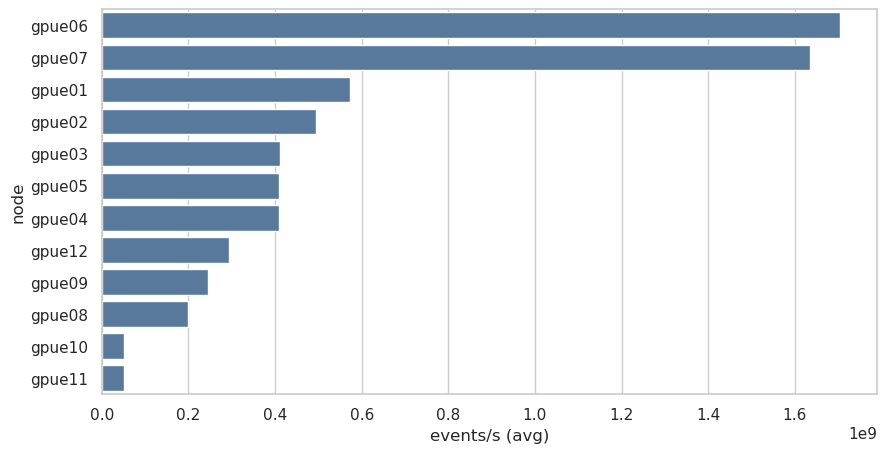

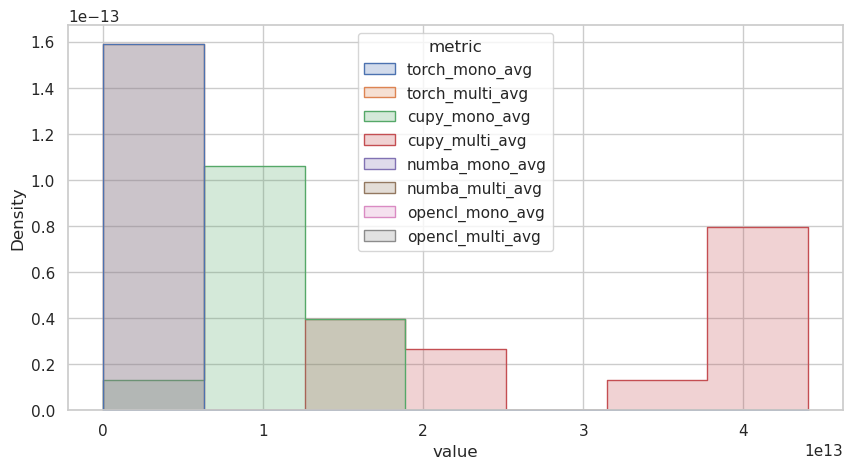

In [7]:
# Section 6 — Visualisations (lignes/évolution si step, sinon barres)

if not cpu_norm.empty:
    display(HTML("<h3>CPU — Meilleures perfs par nœud (mode multi)</h3>"))
    cpu_multi = cpu_norm[cpu_norm.get("mode")=="multi"].copy()
    top_cpu = (cpu_multi
               .sort_values(["node", "avg_events_per_s"], ascending=[True, False])
               .groupby("node", as_index=False).head(1))
    ax = sns.barplot(data=top_cpu.sort_values("avg_events_per_s", ascending=False),
                     x="avg_events_per_s", y="node", color="#4C78A8")
    ax.set_xlabel("events/s (avg)")
    ax.set_ylabel("node")
    plt.show()

if not gpu_long.empty:
    display(HTML("<h3>GPU — Distribution des meilleures métriques (monos et multi)</h3>"))
    g = sns.histplot(data=gpu_long[gpu_long["metric"].str.endswith("_avg")], x="value", hue="metric", element="step", stat="density", common_norm=False)
    plt.show()

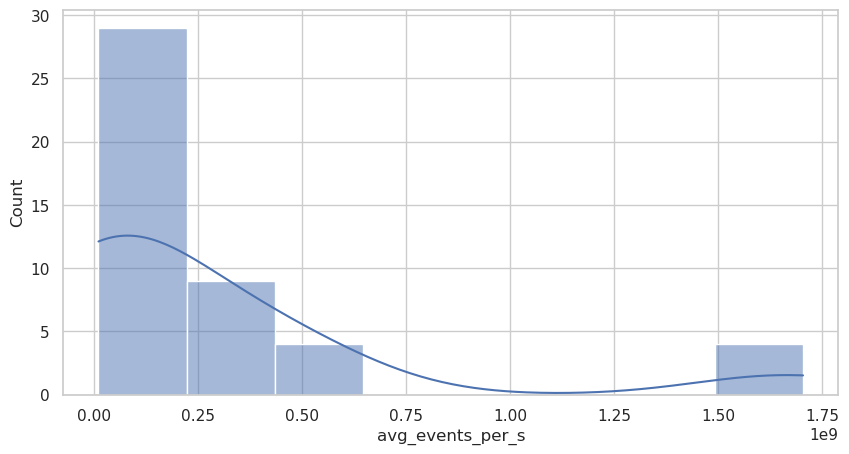

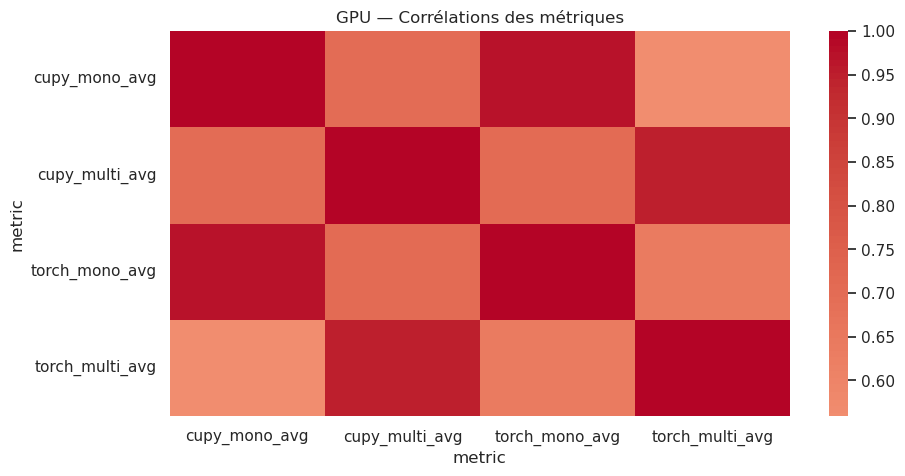

In [8]:
# Section 7 — Distributions et corrélations

if not cpu_norm.empty:
    display(HTML("<h4>CPU — Histogramme avg_events_per_s</h4>"))
    sns.histplot(cpu_norm["avg_events_per_s"].dropna(), kde=True)
    plt.show()

if not gpu_long.empty:
    # Matrice de corrélation sur les moyennes par backend (au format large)
    gpu_avg_wide = (gpu_long[gpu_long["metric"].str.endswith("_avg")] 
                    .pivot_table(index="node", columns="metric", values="value", aggfunc="mean"))
    if not gpu_avg_wide.empty:
        corr = gpu_avg_wide.corr(numeric_only=True)
        sns.heatmap(corr, cmap="coolwarm", center=0)
        plt.title("GPU — Corrélations des métriques")
        plt.show()

,node,mode,threads,runs,duration_s,avg_events_per_s,stddev_events_per_s,timestamp,source_file,kind
21,gpue06,multi,64,3,2.0,1.704417e+09,4.020428e+07,2025-09-05 01:17:48+00:00,cpu_gpue06.csv,cpu
25,gpue07,multi,64,3,2.0,1.634246e+09,2.426446e+07,2025-09-05 01:17:49+00:00,cpu_gpue07.csv,cpu
1,gpue01,multi,56,3,2.0,5.739925e+08,1.490126e+06,2025-09-05 01:17:51+00:00,cpu_gpue01.csv,cpu
7,gpue02,multi,48,3,2.0,4.935827e+08,7.204324e+05,2025-09-05 08:09:37+00:00,cpu_gpue02.csv,cpu
11,gpue03,multi,40,3,2.0,4.112524e+08,1.194569e+05,2025-09-05 08:09:36+00:00,cpu_gpue03.csv,cpu
17,gpue05,multi,40,3,2.0,4.098008e+08,1.549240e+06,2025-09-05 01:17:49+00:00,cpu_gpue05.csv,cpu
13,gpue04,multi,40,3,2.0,4.096564e+08,1.178303e+05,2025-09-05 01:17:49+00:00,cpu_gpue04.csv,cpu
45,gpue12,multi,32,3,2.0,2.937194e+08,8.216509e+05,2025-09-05 08:09:37+00:00,cpu_gpue12.csv,cpu
35,gpue09,multi,32,3,2.0,2.452200e+08,9.111015e+05,2025-09-05 08:09:37+00:00,cpu_gpue09.csv,cpu
31,gpue08,multi,24,3,2.0,1.997251e+08,1.018045e+06,2025-09-05 08:09:36+00:00,cpu_gpue08.csv,cpu


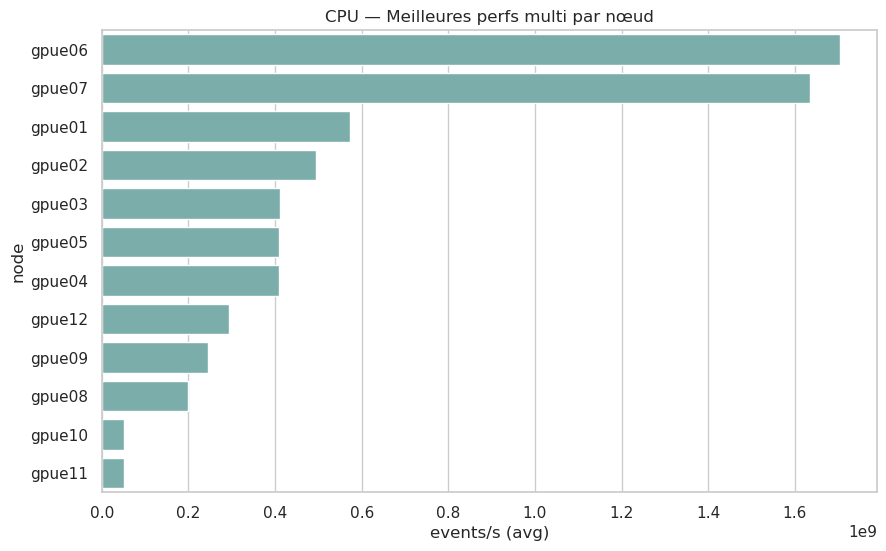

,node,runs,duration_s,timestamp,source_file,kind,metric,value
84,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,cupy_multi_avg,2.223607e+13
60,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,cupy_mono_avg,1.122233e+13
24,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,torch_multi_avg,9.728833e+10
0,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,torch_mono_avg,4.873039e+10
120,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,numba_mono_avg,NaN
144,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,numba_multi_avg,NaN
180,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,opencl_mono_avg,NaN
204,gpue01,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue01.csv,gpu,opencl_multi_avg,NaN
85,gpue02,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue02.csv,gpu,cupy_multi_avg,4.319693e+13
61,gpue02,3,2.0,2025-09-05 03:16:27+00:00,gpu_gpue02.csv,gpu,cupy_mono_avg,1.082450e+13


In [9]:
# Section 8 — Comparaison multi-runs (métriques et paramètres)

# Pour CPU: tableau des meilleures perfs multi par nœud
comp_cpu = pd.DataFrame()
if not cpu_norm.empty:
    cpu_multi = cpu_norm[cpu_norm.get("mode")=="multi"].copy()
    comp_cpu = (cpu_multi
                .sort_values(["node", "avg_events_per_s"], ascending=[True, False])
                .groupby("node", as_index=False).head(1))
    display(comp_cpu.sort_values("avg_events_per_s", ascending=False).head(20))

    plt.figure(figsize=(10,6))
    sns.barplot(data=comp_cpu.sort_values("avg_events_per_s", ascending=False),
                x="avg_events_per_s", y="node", color="#72B7B2")
    plt.title("CPU — Meilleures perfs multi par nœud")
    plt.xlabel("events/s (avg)")
    plt.show()

# Pour GPU: meilleurs *_avg par nœud et par metric
comp_gpu = pd.DataFrame()
if not gpu_long.empty:
    comp_gpu = (gpu_long[gpu_long["metric"].str.endswith("_avg")] 
                .sort_values(["node", "value"], ascending=[True, False])
                .groupby(["node", "metric"], as_index=False).head(1))
    display(comp_gpu.head(20))

    fig = px.bar(comp_gpu.sort_values("value", ascending=False).head(50),
                 x="value", y="node", color="metric",
                 title="GPU — Meilleures métriques par nœud (top 50)")
    fig.show()

In [10]:
# Section 9 — Filtres interactifs (ipywidgets)

have_widgets = False
try:
    import ipywidgets as widgets
    from ipywidgets import interact, interactive, HBox, VBox
    have_widgets = True
except Exception as e:
    print("ipywidgets non disponible:", e)

if have_widgets:
    # GPU: sélection de la métrique *_avg
    gpu_metrics = sorted({m for m in gpu_long.get("metric", []) if str(m).endswith("_avg")}) if not gpu_long.empty else []
    if gpu_metrics:
        @widgets.interact(metric=gpu_metrics)
        def _gpu_metric_hist(metric=gpu_metrics[0]):
            df = gpu_long[(gpu_long.metric == metric)]
            fig = px.histogram(df, x="value", color="backend", marginal="box",
                               title=f"Distribution {metric}")
            fig.show()
    else:
        print("Pas de métriques GPU *_avg trouvées.")

    # CPU: sélection mode et top N
    if not cpu_norm.empty:
        modes = sorted(cpu_norm["mode"].dropna().unique())
        @widgets.interact(mode=modes, topN=widgets.IntSlider(min=5, max=50, step=5, value=20))
        def _cpu_top(mode=modes[0], topN=20):
            df = (cpu_norm[cpu_norm.mode==mode]
                  .sort_values("avg_events_per_s", ascending=False)
                  .head(topN))
            plt.figure(figsize=(10, min(8, 0.4*len(df))))
            sns.barplot(data=df, x="avg_events_per_s", y="node", color="#4C78A8")
            plt.title(f"CPU — Top {topN} ({mode})")
            plt.xlabel("events/s (avg)")
            plt.tight_layout()
            plt.show()
else:
    print("Activer ipywidgets pour utiliser les filtres interactifs (voir Section 1).")

interactive(children=(Dropdown(description='metric', options=('cupy_mono_avg', 'cupy_multi_avg', 'numba_mono_a…

interactive(children=(Dropdown(description='mode', options=('mono', 'multi'), value='mono'), IntSlider(value=2…

In [11]:
# Section 10 — Export des figures et des sous-ensembles
from pathlib import Path

EXPORT_DIR = Path(FIGURES_DIR) if 'FIGURES_DIR' in globals() else Path('figures')
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Exemples d'exports CSV/Parquet
if not all_runs.empty:
    out_csv = EXPORT_DIR / 'runs_all_clean.csv'
    out_parquet = EXPORT_DIR / 'runs_all_clean.parquet'
    try:
        all_runs.to_csv(out_csv, index=False)
        print("CSV exporté:", out_csv)
    except Exception as e:
        print("CSV non exporté:", e)
    try:
        all_runs.to_parquet(out_parquet)
        print("Parquet exporté:", out_parquet)
    except Exception as e:
        print("Parquet non exporté:", e)

# Export de quelques figures récentes (si présentes)
try:
    plt.gcf()
    plt.savefig(EXPORT_DIR / 'dernier_plot_matplotlib.png', dpi=150, bbox_inches='tight')
    print("Figure Matplotlib exportée ->", EXPORT_DIR / 'dernier_plot_matplotlib.png')
except Exception as e:
    pass

# Pour Plotly, sauvegarde HTML (dernier fig) si accessible via variable fig
try:
    if 'fig' in globals() and fig is not None:
        fig.write_html(str(EXPORT_DIR / 'dernier_plot_plotly.html'))
        print("Figure Plotly exportée ->", EXPORT_DIR / 'dernier_plot_plotly.html')
except Exception as e:
    pass

print("Exports terminés.")

CSV exporté: figures/runs_all_clean.csv
Parquet exporté: figures/runs_all_clean.parquet
Figure Matplotlib exportée -> figures/dernier_plot_matplotlib.png
Figure Plotly exportée -> figures/dernier_plot_plotly.html
Exports terminés.


<Figure size 1000x500 with 0 Axes>